# Machine Learning with scikit-learn

## Continuous target values

For a regression, we want a range of target values, not a binary category. Having one-hot encoded binary features with a target that is more ordinal than continuous is close to the worst case for using a regression. It's time to move away from the "Learning about Humans learning ML" dataset. We will use a well-known example dataset that is included with scikit-learn for this next section.

## Sample datasets

A number of sample datasets are included with scikit-learn, either already bundled with a `load_*()` function for the smaller ones or with a `fetch_*()` function for the larger ones that can be obtained online. The `make_*()` functions create synthetic datasets with some randomness in their generation.

In [1]:
from sklearn import datasets
[attr for attr in dir(datasets) if not attr.startswith('_')]

['base',
 'california_housing',
 'clear_data_home',
 'covtype',
 'dump_svmlight_file',
 'fetch_20newsgroups',
 'fetch_20newsgroups_vectorized',
 'fetch_california_housing',
 'fetch_covtype',
 'fetch_kddcup99',
 'fetch_lfw_pairs',
 'fetch_lfw_people',
 'fetch_mldata',
 'fetch_olivetti_faces',
 'fetch_rcv1',
 'fetch_species_distributions',
 'get_data_home',
 'kddcup99',
 'lfw',
 'load_boston',
 'load_breast_cancer',
 'load_diabetes',
 'load_digits',
 'load_files',
 'load_iris',
 'load_linnerud',
 'load_mlcomp',
 'load_sample_image',
 'load_sample_images',
 'load_svmlight_file',
 'load_svmlight_files',
 'load_wine',
 'make_biclusters',
 'make_blobs',
 'make_checkerboard',
 'make_circles',
 'make_classification',
 'make_friedman1',
 'make_friedman2',
 'make_friedman3',
 'make_gaussian_quantiles',
 'make_hastie_10_2',
 'make_low_rank_matrix',
 'make_moons',
 'make_multilabel_classification',
 'make_regression',
 'make_s_curve',
 'make_sparse_coded_signal',
 'make_sparse_spd_matrix',
 'make_

## California housing data

One downloadable dataset is the California housing data.  It has a target of house price, and 8 features.  There are 20 thousands samples in it, so it is reasonably large sized.  That is, it is nowhere close to the modern datasets of millions or billions of observations we sometimes work with; but it is also not a toy dataset of dozens or hundreds of observations that are often shown for demonstration purposes (including in prior lessons of this course).

In [2]:
# To demonstrate downloading, remove cached version of dataset
!ls ~/scikit_learn_data
!rm ~/scikit_learn_data/*

cal_housing_py3.pkz


In [3]:
california = datasets.california_housing.fetch_california_housing()

In [4]:
print(california.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




For convenience, it is often useful to massage the standard format of scikit-learn dataset objects.  These objects all have a attributes `.DESCR`, `.feature_names`, `.data`, `.target`.  The latter two are NumPy arrays.  The feature names are simply a Python list of strings.  The description is a single string that has newlines and simple formatting with citations and links inside it.

The California housing dataset has a fairly brief description.  For comparison, the Boston housing dataset has fewer observations but more citational detail.

In [5]:
print(datasets.load_boston().DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [6]:
california.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
print("Features:", california.data.shape, california.data.dtype)
print("Target:", california.target.shape, california.target.dtype)

Features: (20640, 8) float64
Target: (20640,) float64


In [8]:
# One DataFrame for everything
import pandas as pd
df_ca = pd.DataFrame(california.data, columns=california.feature_names)
df_ca['TARGET'] = california.target
df_ca.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We might wonder what the units are for the target variable of house price.  Consulting the [function documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) we can determine that is multiples of $100,000 (presumably 1997 dollars and prices, given citation).

Looking at some summary statistics is always worthwhile before we jump into our actual model.

In [9]:
df_ca.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## Comparing a gaggle of regressors

The DataFrame is useful for getting sense of the data, but for scikit-learn itself, we simply want to work with the `.data` and `.target` arrays.

In [10]:
X = california.data
y = california.target

For validation—as usual—we want a train/test split.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

The metrics we use in the below code are `explained_variance_score`, `mean_absolute_error`, and `r2_score`. Many other metrics are are available, mostly within the `sklearn.metrics` submodule.

In [12]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

The particular regressors we choose does not reflect any deep decision. Most are somewhat in the family of linear regression. RANSAC is tried because it is meant to be more resilient against outliers in data. This is sometimes more strongly predictive than generic linear regression. One of several Guassian techniques is shown as an example—it behaves worthlessly for this example, at least without hyperparameter tuning.

In [13]:
r2_score?

Signature: r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average')
Docstring:
R^2 (coefficient of determination) regression score function.

Best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.0.

Read more in the :ref:`User Guide <r2_score>`.

Parameters
----------
y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape = (n_samples), optional
    Sample weights.

multioutput : string in ['raw_values', 'uniform_average', 'variance_weighted'] or None or array-like of shape (n_outputs)

    Defines aggregating of multiple output scores.
    Array-like value defines weights used to average scores.
    Default is "uni

In [17]:
from time import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

regressors = [
    LinearRegression(), 
    RANSACRegressor(), 
    KNeighborsRegressor(),
    KNeighborsRegressor(n_neighbors=9, metric='manhattan'),
    SVR(),
    LinearSVR(),
    GaussianProcessRegressor(),
    SVR(kernel='linear'), # Cf. LinearSVR: much slower, might be better or worse: 
]

In [16]:
head = 6
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    predictions = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs)" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, predictions))
    print("\tMean absolute error:", mean_absolute_error(y_test, predictions))
    print("\tR2 score:", r2_score(y_test, predictions))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
	Training time: 0.250s)
	Prediction time: 0.000s
	Explained variance: 0.593250730524
	Mean absolute error: 0.535100844528
	R2 score: 0.592986928576
RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_metric=None,
        residual_threshold=None, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)
	Training time: 0.086s)
	Prediction time: 0.000s
	Explained variance: 0.458140589079
	Mean absolute error: 0.560287128379
	R2 score: 0.453251271546
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
	Training time: 0.012s)
	Prediction time: 0.023s
	Explained variance: 0.133375465369
	Mean absolute error: 0.823986941473
	R2 score: 0.132738243228
KNeighborsRe

Two models that are very slow to train are omitted in the "live" output in this course.  Those outputs would be the following:

```
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)
    Training time: 161.517s
    Prediction time: 4.571s
    Explained variance: -0.0199393545636
    Mean absolute error: 1.91320341763
    R2 score: -2.79445305731
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
    Training time: 4458.012s
    Prediction time: 0.843s
    Explained variance: 0.527882057056
    Mean absolute error: 0.601893862699
    R2 score: 0.517431654021
```

Neither of these has an especially good R2 score for this particular data.  `GaussianProcessRegressor` is negative, in fact (which is very bad).  `SVR` with a linear kernel is moderately good, but not better than simple `LinearRegression`.  However, notice that even though training took well over an hour, prediction takes less than a second.  That is not the fasted predictor, but it is also not the slowest among those that train orders of magnitude faster.  If this model performed the best, it might be worth spending the one-time training cost, and then be able to regress sufficiently quickly.

## Linear models

With high dimensionality, plain linear regression tends to perform surprisingly well.  Variants may add improvements, but this technique from general statistics, or analytic math, is quite good—notwithstanding that it basically pre-dates machine learning per se.  A simple linear regression basically assumes the following:

* as a feature value varies, the target value varies proportionally
  * responses to features are global
  * responses are strictly linear
* features are not co-linear

Even if these assumptions are not stricly true, the model may perform well.  One common strategy to mitigate variance from these assumptions is to *penalize* the weights (coefficients) assigned to each feature.  An "$l1$ penalty" is known as Lasso regression and will force some coefficients to zero.  An $l2$ penalty is known as Ridge regression and damps coefficients.

### Equations and visualizations for penalties

In more detail, I plain linear regression is this calculation:

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2 $$

For Lasso regression (**L**east **a**bsolute **s**hrinkage **s**election **o**perator), the equation is:

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_1$$

For Ridge regression, the equation is:

$$ \text{min}_{w,b}  \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_2^2$$ 

The second term in the right hand side of the equation below is the L2 regularization that is part of ridge regression ($\alpha$ is usually chosen between 0.01 and 100).  The idea in Ridge regression is to mutually minimize the error terms and the penalty constant.

It is probably easier to visualize these than look at the equations.  Ridge regression may be a good choice when there are colinear predictors in the `X` matrix.  In the simplest characterization, Ridge pulls the OLS (ordinary least square) estimators closer to zero (but not actually set them to exactly zero).

![Geometric Interpretation of Ridge Regression](img/ridge_regression_geomteric.png)

Contrasting Lasso and Ridge (or $l1$ versus $l2$) we can visualize the difference as below.  Notice that some coefficients are actually zeroes in the Lasso model.

![L1 versus L2 regions](img/L1_and_L2_balls.png)

Let's try this all out.

In [24]:
from sklearn.linear_model import Lasso, Ridge

lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()

for model in [lr, lasso, ridge]:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(model)
    print("\tExplained variance:", explained_variance_score(y_test, predictions))
    print("\tMean absolute error:", mean_absolute_error(y_test, predictions))
    print("\tR2 score:", r2_score(y_test, predictions))
    print()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
	Explained variance: 0.593250730524
	Mean absolute error: 0.535100844528
	R2 score: 0.592986928576

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
	Explained variance: 0.289706904741
	Mean absolute error: 0.765863407043
	R2 score: 0.288879512535

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
	Explained variance: 0.593248514704
	Mean absolute error: 0.535109962954
	R2 score: 0.592984667158



## Pitfalls of linear models

Famously, there can be many features of data that are not well captured in any (naïve) linear model. [Francis Anscombe](https://en.wikipedia.org/wiki/Frank_Anscombe) created his [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) as an illustration of this. The several distributions in it have nearly the same or identical means and variances along X and Y axes, have almost the same correlations of X and Y, have the same linear regression lines and coefficient of determination. 

Let us look at some basic statistics and regressions on this data. Let us also look at the statistical properties of the elements of the quartet. In particular, notice the means and standard deviations (of both the x and y features), and the min/max and quartiles of the first three x feature collections.

This sample dataset is included in the Seaborn visualization library:

In [36]:
import seaborn as sns
df = sns.load_dataset("anscombe")
df.pivot(columns='dataset').describe()

x                                           y             \
dataset          I         II        III         IV          I         II   
count    11.000000  11.000000  11.000000  11.000000  11.000000  11.000000   
mean      9.000000   9.000000   9.000000   9.000000   7.500909   7.500909   
std       3.316625   3.316625   3.316625   3.316625   2.031568   2.031657   
min       4.000000   4.000000   4.000000   8.000000   4.260000   3.100000   
25%       6.500000   6.500000   6.500000   8.000000   6.315000   6.695000   
50%       9.000000   9.000000   9.000000   8.000000   7.580000   8.140000   
75%      11.500000  11.500000  11.500000   8.000000   8.570000   8.950000   
max      14.000000  14.000000  14.000000  19.000000  10.840000   9.260000   

                               
dataset        III         IV  
count    11.000000  11.000000  
mean      7.500000   7.500909  
std       2.030424   2.030579  
min       5.390000   5.250000  
25%       6.250000   6.170000  
50%       7.110000   7.040000  
75%       7.980000   8.190000  
max      12.740000  12.500000

The overall data collection has similar (but not quite identical) properties to its subsects.

We might hope to tease apart what is going on with the several subsets by looking at the correlation of the features. Other than some floating point approximations, these are also identical.

In [37]:
import numpy as np

df_1 = df[df.dataset=='I']
df_2 = df[df.dataset=='II']
df_3 = df[df.dataset=='III']
df_4 = df[df.dataset=='IV']

(np.corrcoef(df_1.x, df_1.y)[1,0],
 np.corrcoef(df_2.x, df_2.y)[1,0],
 np.corrcoef(df_3.x, df_3.y)[1,0],
 np.corrcoef(df_4.x, df_4.y)[1,0])

(0.81642051634483992,
 0.81623650600024267,
 0.81628673948959807,
 0.81652143688850298)

Actually visualizing the data gives us a very distinctly different impression of the data subsets.  The linear regressions are identical (under an [ordinary least squares fit](https://en.wikipedia.org/wiki/Ordinary_least_squares) here, but the point would be the same with a different fitting regime).

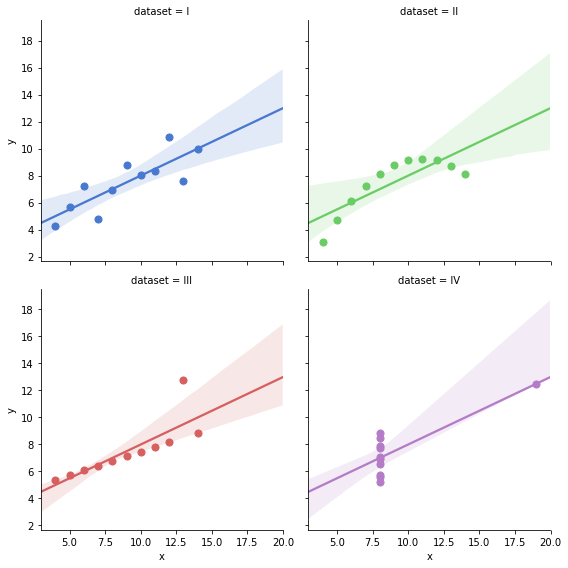

In [38]:
%matplotlib inline
# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1});

Humorously, Justin Matejka and George Fitzmaurice give a similar example with the [Datasaurus](https://www.autodeskresearch.com/publications/samestats) in _Same Stats, Different Graphs: Generating Datasets with Varied Appearance and Identical Statistics through Simulated Annealing_:

<img src="img/DataDino-600x455.gif" width="50%"/>

### The moral of the pitfalls

Obviously, the concerns raised by Anscombe hardly mean we should not use linear models.  In the examples we have looked at, basic OLS linear regression performed as well or better than all the other models we tried.  But there are certainly special cases where linear regression will be unable to distingish distributions whereas other techniques might be able to.

There is a tradeoff in these kinds of situations between two approaches.  One approach would be to use more feature engineering and general data cleanup before we get to our linear regression step.  We will think about those possibilities in later chapters.  Onother approach is to choose a different family of model from the start, and avoid the particular pitfalls the linear models have (but encounter other pitfalls in their place).